## Import the Required Packages

In [115]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.formula.api import ols

import pybaseball

## Download the Data & Add Year Label & Merge the Tables


In [74]:
data2014 = pybaseball.schedule_and_record(2014, 'TOR')
data2014['Year'] = '2014'

data2015 = pybaseball.schedule_and_record(2015, 'TOR')
data2015['Year'] = '2015'

data2016 = pybaseball.schedule_and_record(2016, 'TOR')
data2016['Year'] = '2016'

data2017 = pybaseball.schedule_and_record(2017, 'TOR')
data2017['Year'] = '2017'

data = pd.concat([data2014, data2015, data2016, data2017], axis=0, join='outer', join_axes=None, ignore_index=True)


## Cleaning the data to work with
- Cleaned the Days so they work as date times. 


#### Potential Future Work
- We may need to clean the playoff games out of the years that TOR made the playoffs, because they will be extra games on the end of the season with 100% capacity. Could bias the accuracy for those seasons. I'm not sure how we find them easily though. 

In [75]:
# Split the Date up
data[['DOW','Cal_Date']] = data['Date'].str.split(',',expand=True)
data[['Blank', 'Month', 'Day', 'Double_Header']] = data['Cal_Date'].str.split('\s', expand=True)

# The whole reason I had to split it up. Python can't cope with single digit day formats. 
data['Day'] = data['Day'].str.zfill(2)

# Compile it all back up and convert to a datetime
data['Date'] = pd.to_datetime((data['Month'] + data['Day'] + data['Year']), format='%b%d%Y')

data.rename(columns={'D/N':'Day_Night'}, inplace=True)

# Clean up the interim fields I had to make
data = data.drop(['Cal_Date', 'Blank', 'Month', 'Day'], axis=1)

data['DOW'] = pd.Categorical(data['DOW'], categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'], ordered=True)

In [49]:
# data.to_csv('data.csv')

In [3]:
# Emergency Data Read In/Out
# data.to_csv('data.csv')
# data = pd.read_csv('data.csv')

## Filter the data

In [83]:
home_games = data[data['Home_Away'] == 'Home']
home_games['Capacity'] = 49282

/Users/Margaret/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [84]:
home_games['% Capacity'] = home_games['Attendance']/home_games['Capacity']

/Users/Margaret/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## Explore the Data

In [85]:
home_games.head()

,Date,Tm,Home_Away,Opp,W/L,R,RA,Inn,W-L,Rank,...,Time,Day_Night,Attendance,Streak,Orig. Scheduled,Year,DOW,Double_Header,Capacity,% Capacity
4,2014-04-04,TOR,Home,NYY,L,3.0,7.0,9.0,2-3,4.0,...,3:26,N,48197.0,-2,None,2014,Friday,None,49282,0.977984
5,2014-04-05,TOR,Home,NYY,W,4.0,0.0,9.0,3-3,2.0,...,2:45,D,45446.0,1,None,2014,Saturday,None,49282,0.922162
6,2014-04-06,TOR,Home,NYY,L,4.0,6.0,9.0,3-4,3.0,...,2:57,D,34067.0,-1,None,2014,Sunday,None,49282,0.691267
7,2014-04-08,TOR,Home,HOU,W,5.0,2.0,9.0,4-4,2.0,...,2:52,N,13123.0,1,None,2014,Tuesday,None,49282,0.266284
8,2014-04-09,TOR,Home,HOU,W,7.0,3.0,9.0,5-4,1.0,...,3:09,N,13569.0,2,None,2014,Wednesday,None,49282,0.275334


In [86]:
home_games.agg({'Streak':'count', 'Attendance': 'mean', '% Capacity': 'mean'})

Streak          324.000000
Attendance    36316.052469
% Capacity        0.736903
dtype: float64

In [87]:
home_games.groupby(['Year']).agg({'Streak':'count', 'Attendance': 'mean', '% Capacity': 'mean'})

,Streak,Attendance,% Capacity
Year,,,
2014,81,29327.469136,0.595095
2015,81,34504.827160,0.700151
2016,81,41877.765432,0.849758
2017,81,39554.148148,0.802608


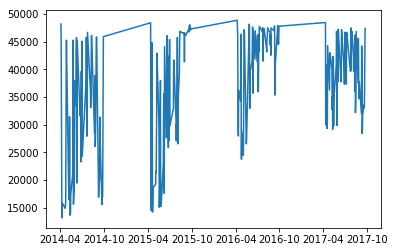

In [88]:
plt.plot(home_games['Date'], home_games['Attendance'])
plt.show()

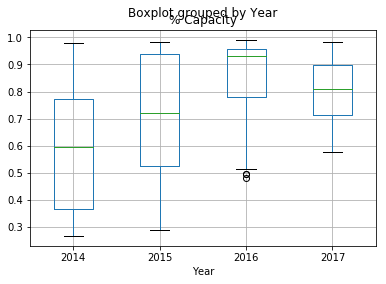

In [89]:
home_games.boxplot('% Capacity','Year')
plt.show()

In [90]:
home_games.groupby(['DOW']).agg({'Streak':'count', 'Attendance': 'mean', '% Capacity': 'mean'})

,Streak,Attendance,% Capacity
DOW,,,
Monday,34,30741.558824,0.623789
Tuesday,50,31139.080000,0.631855
Wednesday,50,32196.480000,0.653311
Thursday,34,32915.323529,0.667897
Friday,52,36978.250000,0.750340
Saturday,52,43263.634615,0.877879
Sunday,52,43513.673077,0.882953


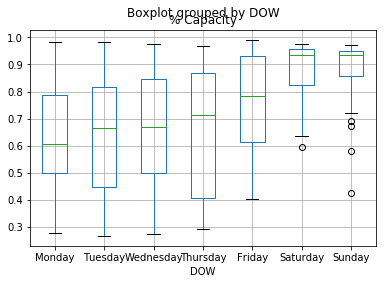

In [105]:
home_games.boxplot('% Capacity','DOW')
plt.show()

In [92]:
home_games.groupby(['Rank']).agg({'Streak':'count', 'Attendance': 'mean', '% Capacity': 'mean'})

,Streak,Attendance,% Capacity
Rank,,,
1.0,60,37998.600000,0.771044
2.0,67,36639.059701,0.743457
3.0,79,35157.164557,0.713388
4.0,32,31980.500000,0.648929
5.0,86,37568.325581,0.762313


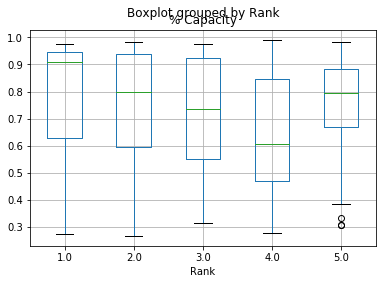

In [93]:
home_games.boxplot('% Capacity','Rank')
plt.show()

In [94]:
home_games.groupby(['Streak']).agg({'Streak':'count', 'Attendance': 'mean', '% Capacity': 'mean'})

,Streak,Attendance,% Capacity
Streak,,,
-7,1,39547.000000,0.802463
-6,1,32957.000000,0.668743
-5,2,29498.500000,0.598565
-4,8,41345.250000,0.838952
-3,14,34185.000000,0.693661
-2,33,36477.878788,0.740187
-1,78,36065.794872,0.731825
1,85,37477.811765,0.760477
2,42,36132.666667,0.733182


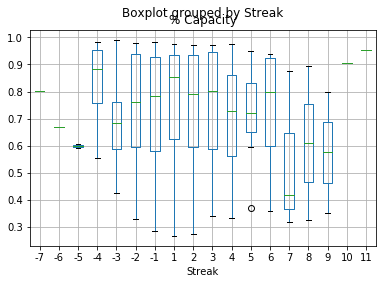

In [95]:
home_games.boxplot('% Capacity','Streak')
plt.show()

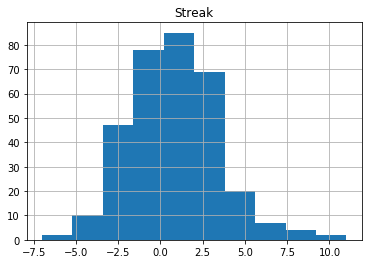

In [96]:
home_games.hist('Streak')
plt.show()

In [97]:
home_games.groupby(['Day_Night']).agg({'Streak':'count', 'Attendance': 'mean', '% Capacity': 'mean'})

,Streak,Attendance,% Capacity
Day_Night,,,
D,125,42903.48800,0.870571
N,199,32178.21608,0.652941


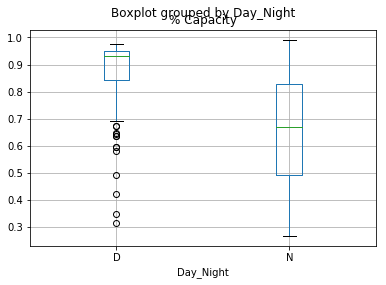

In [98]:
home_games.boxplot('% Capacity','Day_Night')
plt.show()

## Model the Variables

In [135]:
## First, we're looking at the four main variables without considering their interactions. 
## This isn't super valid because it's missing the interactions between the variables
## It's telling us what out of these are worth looking at more. 

model = ols('Attendance ~ C(Streak) + C(DOW) + C(Year) + C(Day_Night)', data=home_games).fit()
print(model.summary())
print()
table = sm.stats.anova_lm(model, typ=3)
print(table)

                            OLS Regression Results                            
Dep. Variable:             Attendance   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     12.69
Date:                Mon, 02 Apr 2018   Prob (F-statistic):           2.25e-35
Time:                        19:45:22   Log-Likelihood:                -3333.6
No. Observations:                 324   AIC:                             6723.
Df Residuals:                     296   BIC:                             6829.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            3.132e+04   7

### 5.506717e-01 is telling me that streak is not actually a statistically significant factor in the analysis. 

In [136]:
## Now I'm looking at the three identified as being significant
model = ols('Attendance ~ C(DOW)*C(Year)*C(Day_Night)', data=home_games).fit()
print(model.summary())
print()
table = sm.stats.anova_lm(model, typ=1)
#I don't know why type 1 works but type 3 fails on linalb matrix 
print(table)

                            OLS Regression Results                            
Dep. Variable:             Attendance   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     9.267
Date:                Mon, 02 Apr 2018   Prob (F-statistic):           4.61e-32
Time:                        19:45:45   Log-Likelihood:                -3325.2
No. Observations:                 324   AIC:                             6730.
Df Residuals:                     284   BIC:                             6882.
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                                                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

/Users/Margaret/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/Margaret/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/Margaret/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/Margaret/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


### facinating, none of the interactions are statistically significant. 

In [137]:
model = ols('Attendance ~ C(DOW) + C(Year) + C(Day_Night)', data=home_games).fit()
print(model.summary())
print()
table = sm.stats.anova_lm(model, typ=3)
print(table)

                            OLS Regression Results                            
Dep. Variable:             Attendance   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     32.85
Date:                Mon, 02 Apr 2018   Prob (F-statistic):           3.15e-43
Time:                        19:45:58   Log-Likelihood:                -3341.9
No. Observations:                 324   AIC:                             6706.
Df Residuals:                     313   BIC:                             6747.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            3.256e+04   2

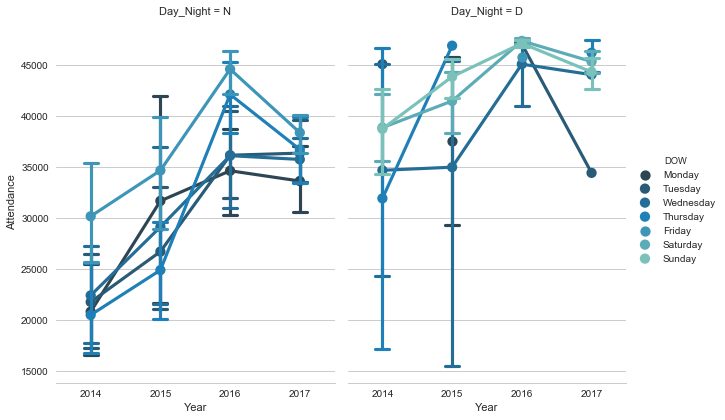

In [138]:
import seaborn as sns
sns.set(style="whitegrid")

# Load the example exercise dataset
# df = sns.load_dataset("home_games")

# Draw a pointplot to show pulse as a function of three categorical factors
g = sns.factorplot(x="Year", y="Attendance", hue = "DOW", col="Day_Night", data=home_games,
                   capsize=.2, palette="YlGnBu_d", size=6, aspect=.75)
g.despine(left=True)